
Procedo a analizar la relacion entre el codigo burocratico y si la operacion
es exitosa o no en base al porcentaje de closed Won sobre closed Lost.

In [103]:
import pandas as pd
import seaborn as sns

data = pd.read_csv('Entrenamieto_ECI_2020.csv').drop_duplicates(subset=['Opportunity_ID'])
#No cuento opportunities repetidos, el resultado igual es por opportunity
#y no por producto asi que no es que pierdo resultados

data.replace(to_replace=['Bureaucratic_Code_0', 'Bureaucratic_Code_1', 'Bureaucratic_Code_2',
                                     'Bureaucratic_Code_3', 'Bureaucratic_Code_4',
                                     'Bureaucratic_Code_5', 'Bureaucratic_Code_6'],
                         value=['0', '1', '2', '3', '4', '5', '6'], inplace=True)

bureaucraticCode = data[['Bureaucratic_Code', 'Stage']]

bureaucraticCode = bureaucraticCode[bureaucraticCode['Stage'].isin(values=['Closed Won', 'Closed Lost'])]

bureaucraticCode.replace(to_replace=['Closed Won', 'Closed Lost'], value=[1, 0], inplace=True)

Analizo cuantos datos tengo de cada Bureaucratic Code para ver cuales considero
estadisticamente suficientes

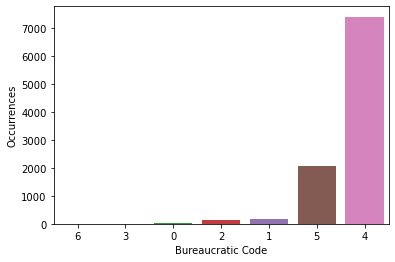

In [104]:
codesCount = bureaucraticCode['Bureaucratic_Code'].value_counts().to_frame().reset_index().sort_values('Bureaucratic_Code')

sns.barplot(x='Bureaucratic Code', y='Occurrences', data=(codesCount.rename(columns=
            {'index':'Bureaucratic Code', 'Bureaucratic_Code':'Occurrences'})), order=codesCount['index'])

Cambiando la escala para ver los Codes con menores ocurrencias

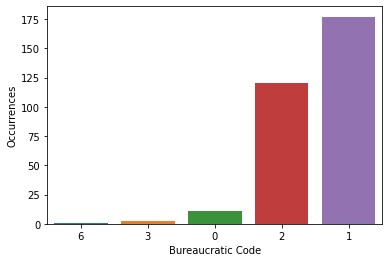

In [105]:
codesCount = codesCount[(codesCount['index'] != '4') & (codesCount['index'] != '5')]
sns.barplot(x='Bureaucratic Code', y='Occurrences', data=(codesCount.rename(columns=
            {'index':'Bureaucratic Code', 'Bureaucratic_Code':'Occurrences'})),
            order=codesCount['index'])

Como para los codigos burocraticos 0, 3 y 6 tenemos menos de 20 datos no los tomaremos en cuenta
para el analisis, quedandonos entonces solo con los codigos 1,2,4 y 5.

Tenemos entonces que el rate de oportunidades ganadas para las oportunidades con estos
codigos burocraticos es

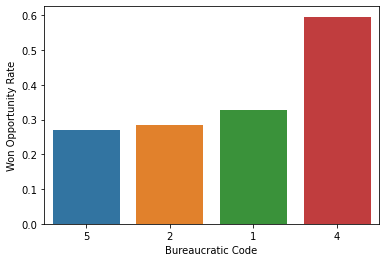

In [106]:
validStatisticalCodes = ['1', '2', '4', '5']

wonOpportunityRate = bureaucraticCode[(bureaucraticCode['Bureaucratic_Code'].isin(validStatisticalCodes))]\
                    .groupby('Bureaucratic_Code').agg({'Stage':'mean'}).reset_index().sort_values('Stage')

wonOpportunityRate.rename(columns={'Bureaucratic_Code':'Bureaucratic Code', 'Stage':'Won Opportunity Rate'}, inplace=True)

sns.barplot(x='Bureaucratic Code', y='Won Opportunity Rate', data=wonOpportunityRate,
            order=wonOpportunityRate['Bureaucratic Code'])

Ahora veremos si hay alguna relacion entre los codigos burocraticos y no pagar impuestos.
Quiza algunos codigos burocraticos esten mas excentos de pagarle al fisco.

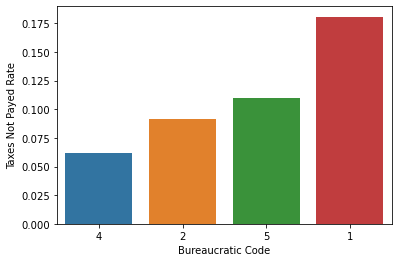

In [107]:
bureaucraticTaxes = data[['Bureaucratic_Code', 'Total_Taxable_Amount']]
bureaucraticTaxes = bureaucraticTaxes[bureaucraticTaxes['Bureaucratic_Code'].isin(validStatisticalCodes)]
#De nuevo, dentro de cada opportunity el Total_Taxable_Amount es igual para todas sus entradas
#asi que dropeo los duplicados

bureaucraticTaxes.loc[bureaucraticTaxes['Total_Taxable_Amount'] != 0, 'Total_Taxable_Amount'] = 1

opportunityDindtPayTaxesRate = bureaucraticTaxes.groupby('Bureaucratic_Code')\
                                    .agg({'Total_Taxable_Amount':'mean'}) #Aca tengo el porcentaje que si pago

opportunityDindtPayTaxesRate = (1 - opportunityDindtPayTaxesRate).reset_index().sort_values('Total_Taxable_Amount') #Me quedo con el porcentaje que no se pago

opportunityDindtPayTaxesRate.rename(columns={'Bureaucratic_Code':'Bureaucratic Code'
            , 'Total_Taxable_Amount':'Taxes Not Payed Rate'}, inplace=True)

sns.barplot(x='Bureaucratic Code', y='Taxes Not Payed Rate', data=opportunityDindtPayTaxesRate,
            order=opportunityDindtPayTaxesRate['Bureaucratic Code'])

Ahora analizo si algunos codigos burocraticos suelen necesitar ser aprobados mas que otros,
y ademas analizo que tanto mas aprobados son.

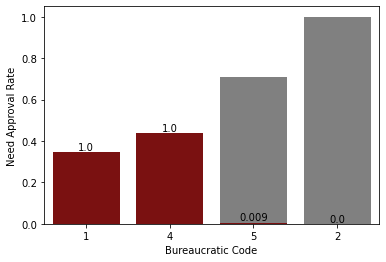

In [108]:
bureaucraticApprovals = data[['Bureaucratic_Code', 'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved']]

bureaucraticApprovals = bureaucraticApprovals[bureaucraticApprovals['Bureaucratic_Code'].isin(validStatisticalCodes)]

bureaucraticApprovals = bureaucraticApprovals.groupby('Bureaucratic_Code').agg({'Bureaucratic_Code_0_Approval':['mean', 'sum'],
                                       'Bureaucratic_Code_0_Approved':'sum'})

bureaucraticApprovals[('','Approved Rate')] = bureaucraticApprovals[('Bureaucratic_Code_0_Approved', 'sum')]  /\
                                         bureaucraticApprovals[('Bureaucratic_Code_0_Approval', 'sum')]

bureaucraticApprovals.drop(['Bureaucratic_Code_0_Approved', ('Bureaucratic_Code_0_Approval', 'sum')], axis=1, inplace=True)

bureaucraticApprovals = bureaucraticApprovals.droplevel(0, axis=1).reset_index().rename(columns={'Bureaucratic_Code':'Bureaucratic Code',
                                                                         'mean':'Need Approval Rate'})\
                .sort_values('Need Approval Rate')

#Hago los graficos que muestran en las barras que porcentaje de ese codigo necesito
#ser aprobado, y en colorcito relleno que porcentaje de esos que necesitaban ser aprobados
#fueron finalmente aprobados

ax = sns.barplot(x='Bureaucratic Code', y='Need Approval Rate', data=bureaucraticApprovals,
           order=bureaucraticApprovals['Bureaucratic Code'], color='grey')

#Reescalo para graficar (o sea, convierto el porcentaje absoluto a porcentaje relativo
#en el grafico para que quede bien el relleno

bureaucraticApprovals['Approved Rate'] = bureaucraticApprovals['Approved Rate']*bureaucraticApprovals['Need Approval Rate']

sns.barplot(x='Bureaucratic Code', y='Approved Rate', data=bureaucraticApprovals,
           order=bureaucraticApprovals['Bureaucratic Code'], color='darkred', ax=ax)

ax.set(ylabel='Need Approval Rate')

i = 0
for index, row in bureaucraticApprovals.iterrows():
    ax.text(i, row['Approved Rate'] + 0.01, round(row['Approved Rate']/row['Need Approval Rate'], 3), color='black', ha="center")
    i = i + 1